# Recognize Exercise Name Using Aggregated Statistics from the Signals
- Model Neural Network
- Cross-validated test cross entropy loss: 0.9979, Cross-validated test accuracy: 0.7598

#### Import libraries

In [6]:
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, udf, greatest, least, struct
from pyspark.sql.types import *
import random
import scipy.signal as signal
import scipy.io
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

## Load Data
Data comes in the format of 1 row for each time point

In [7]:
df = pd.read_csv("../bigfiles/exercise_recognition_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134191 entries, 0 to 6134190
Data columns (total 11 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   set_num     int64  
 2   activity    object 
 3   time        float64
 4   x_gyro      float64
 5   y_gyro      float64
 6   z_gyro      float64
 7   x_acc       float64
 8   y_acc       float64
 9   z_acc       float64
 10  label       float64
dtypes: float64(8), int64(2), object(1)
memory usage: 514.8+ MB


In [8]:
# remove infrequent activities
infrequent_activities = ['Box Jump (on bench)',
 'Lawnmower (label spans both arms)',
 'Overhead Triceps Extension (label spans both arms)']

df = df[~df['activity'].isin(infrequent_activities)]

In [9]:
df_byset = df.groupby(["activity","set_num"])
signal_cols = [col for col in df.columns if col.startswith("x") or col.startswith("y") or col.startswith("z")]


## Data Preprocessing
Compute features: interquartile range, variance, skewness, kurtosis, root mean square error of the signal amplitude
aggregated for each set

In [10]:
df_means = df_byset[signal_cols].mean().add_suffix('_mean')
df_iqr = df_byset[signal_cols].quantile(0.75) - df_byset[signal_cols].quantile(0.25)
df_iqr = df_iqr.add_suffix('_iqr')
df_var = df_byset[signal_cols].var().add_suffix('_var')
df_skew = df_byset[signal_cols].skew().add_suffix('_skew')
df_kurt = df_byset[signal_cols].apply(pd.DataFrame.kurt).add_suffix('_kurt')
df_rms = df_byset[signal_cols].apply(lambda x: np.sqrt(np.mean(x**2))).add_suffix('_rms')

joined = df_means.join(df_iqr).join(df_var).join(df_skew).join(df_kurt).join(df_rms)

In [11]:
joined.columns

Index(['x_gyro_mean', 'y_gyro_mean', 'z_gyro_mean', 'x_acc_mean', 'y_acc_mean',
       'z_acc_mean', 'x_gyro_iqr', 'y_gyro_iqr', 'z_gyro_iqr', 'x_acc_iqr',
       'y_acc_iqr', 'z_acc_iqr', 'x_gyro_var', 'y_gyro_var', 'z_gyro_var',
       'x_acc_var', 'y_acc_var', 'z_acc_var', 'x_gyro_skew', 'y_gyro_skew',
       'z_gyro_skew', 'x_acc_skew', 'y_acc_skew', 'z_acc_skew', 'x_gyro_kurt',
       'y_gyro_kurt', 'z_gyro_kurt', 'x_acc_kurt', 'y_acc_kurt', 'z_acc_kurt',
       'x_gyro_rms', 'y_gyro_rms', 'z_gyro_rms', 'x_acc_rms', 'y_acc_rms',
       'z_acc_rms'],
      dtype='object')

In [12]:
joined.reset_index(inplace=True)
joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631 entries, 0 to 1630
Data columns (total 38 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   activity     1631 non-null   object 
 1   set_num      1631 non-null   int64  
 2   x_gyro_mean  1631 non-null   float64
 3   y_gyro_mean  1631 non-null   float64
 4   z_gyro_mean  1631 non-null   float64
 5   x_acc_mean   1631 non-null   float64
 6   y_acc_mean   1631 non-null   float64
 7   z_acc_mean   1631 non-null   float64
 8   x_gyro_iqr   1631 non-null   float64
 9   y_gyro_iqr   1631 non-null   float64
 10  z_gyro_iqr   1631 non-null   float64
 11  x_acc_iqr    1631 non-null   float64
 12  y_acc_iqr    1631 non-null   float64
 13  z_acc_iqr    1631 non-null   float64
 14  x_gyro_var   1631 non-null   float64
 15  y_gyro_var   1631 non-null   float64
 16  z_gyro_var   1631 non-null   float64
 17  x_acc_var    1631 non-null   float64
 18  y_acc_var    1631 non-null   float64
 19  z_acc_

In [13]:
#joined.to_csv("../bigfiles/exercise_recognition_data_stats2.csv")

## Model - Neural Network

In [45]:
joined_df = joined.reset_index(inplace=False).copy()

In [55]:
# create a function to split the data into training and test sets
# each activity should be in both the training and test sets
def split_train_test(df, test_size=0.4):
    train_set = pd.DataFrame()
    test_set = pd.DataFrame()
    for activity in df.activity.unique(): 
        activity_df = df[df.activity == activity]
        test_rows = int(len(activity_df) * test_size)
        # get a random sample of rows for the test set
        test_set_indices = random.sample(list(activity_df.index), test_rows)
        test_set = test_set.append(activity_df[activity_df.index.isin(test_set_indices)])
        # get the remaining rows for the training set
        train_set = train_set.append(activity_df.drop(test_set_indices))
    return train_set, test_set

In [34]:
class NeuralNetwork(nn.Module):
        def __init__(self, input_size, hidden_size, num_classes):
            super(NeuralNetwork, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.fc2 = nn.Linear(hidden_size, num_classes)
        
        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = self.fc2(x)
            return x
        
def evaluate_model(joined_df):
    train_set, test_set = split_train_test(joined_df)
    pandas_df = train_set
    features = pandas_df.drop(['activity', 'set_num'], axis=1)
    target = pandas_df['activity']
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    feature_tensor = torch.from_numpy(scaled_features).float()
    label_encoder = LabelEncoder()
    encoded_target = label_encoder.fit_transform(target)
    target_tensor = torch.from_numpy(encoded_target).long()

    input_size = feature_tensor.shape[1]
    hidden_size = 64
    num_classes = target_tensor.max().item() + 1  # Number of unique classes
    model = NeuralNetwork(input_size, hidden_size, num_classes)

    criterion = nn.CrossEntropyLoss()  
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Train the Neural Network
    num_epochs = 200
    batch_size = 32
    for epoch in range(num_epochs):
        correct = 0
        total = 0
        running_loss = 0.0

        for i in range(0, feature_tensor.size(0), batch_size):
            batch_features = feature_tensor[i:i+batch_size]
            batch_target = target_tensor[i:i+batch_size]

            # Forward pass
            outputs = model(batch_features)
            loss = criterion(outputs, batch_target)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += batch_target.size(0)
            correct += (predicted == batch_target).sum().item()

            # Track running loss
            running_loss += loss.item()

        # Calculate accuracy and average loss for the epoch
        accuracy = correct / total
        average_loss = running_loss / (feature_tensor.size(0) / batch_size)

        if epoch % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.4f}, Loss: {average_loss:.4f}")

    # Evaluate the Neural Network on the test set
    pandas_df = test_set
    features = test_set.drop(['activity', 'set_num'], axis=1)
    target = pandas_df['activity']

    # Scale the features using the same StandardScaler from the training data to prevent data leakage
    scaled_features = scaler.transform(features) 
    feature_tensor = torch.from_numpy(scaled_features).float()
    encoded_target = label_encoder.transform(target) 
    target_tensor = torch.from_numpy(encoded_target).long()

    # Predict test_set using the trained NN
    test_outputs = model(feature_tensor)
    test_loss = criterion(test_outputs, target_tensor)
    test_loss_value = test_loss.item()

    _, predicted_labels = torch.max(test_outputs, 1)
    test_accuracy = (predicted_labels == target_tensor).sum().item() / len(target_tensor)

    print(f"Test Accuracy: {test_accuracy:.4f} Test Cross-Entropy Loss: {test_loss_value:.4f}")

    return model, accuracy, average_loss, test_accuracy, test_loss_value

In [57]:
# 3-fold cross validation
k = 3
test_loss_values = []
test_accuracies = []
for i in range(3):
    model, train_accuracy, train_average_loss, test_accuracy, test_loss_value = evaluate_model(joined_df)
    print(f"=== Accuracy: {train_accuracy:.4f}, " +
          f"Loss: {train_average_loss:.4f}, Test Accuracy: " +
          f"{test_accuracy:.4f}, Test Loss: {test_loss_value:.4f}")
    test_loss_values.append(test_loss_value)
    test_accuracies.append(test_accuracy)

print(f"Cross-validated test loss: {np.mean(test_loss_values):.4f}, " +
      f"Cross-validated test accuracy: {np.mean(test_accuracies):.4f}")

Epoch [1/200], Accuracy: 0.0151, Loss: 4.1929
Epoch [51/200], Accuracy: 0.3753, Loss: 2.4983
Epoch [101/200], Accuracy: 0.7082, Loss: 1.3858
Epoch [151/200], Accuracy: 0.8249, Loss: 0.8862
Test Accuracy: 0.7441 Test Cross-Entropy Loss: 0.9986
=== Accuracy: 0.8712, Loss: 0.6430, Test Accuracy: 0.7441, Test Loss: 0.9986
Epoch [1/200], Accuracy: 0.0111, Loss: 4.1949
Epoch [51/200], Accuracy: 0.3853, Loss: 2.4716
Epoch [101/200], Accuracy: 0.6972, Loss: 1.3706
Epoch [151/200], Accuracy: 0.8129, Loss: 0.8874
Test Accuracy: 0.7630 Test Cross-Entropy Loss: 0.9765
=== Accuracy: 0.8662, Loss: 0.6486, Test Accuracy: 0.7630, Test Loss: 0.9765
Epoch [1/200], Accuracy: 0.0060, Loss: 4.2264
Epoch [51/200], Accuracy: 0.3340, Loss: 2.5684
Epoch [101/200], Accuracy: 0.6600, Loss: 1.4613
Epoch [151/200], Accuracy: 0.8008, Loss: 0.9529
Test Accuracy: 0.7724 Test Cross-Entropy Loss: 1.0186
=== Accuracy: 0.8501, Loss: 0.6971, Test Accuracy: 0.7724, Test Loss: 1.0186
Cross-validated test loss: 0.9979, Cross

In [18]:
# get the class that is the most incorrectly classified
_, predicted = torch.max(test_outputs, 1)
predicted = predicted.numpy()
predicted = label_encoder.inverse_transform(predicted)
actual = target_tensor.numpy()
actual = label_encoder.inverse_transform(actual)
incorrect = predicted != actual
incorrect_df = test_set[incorrect]

<AxesSubplot:title={'center':'Test Count (activity)'}>

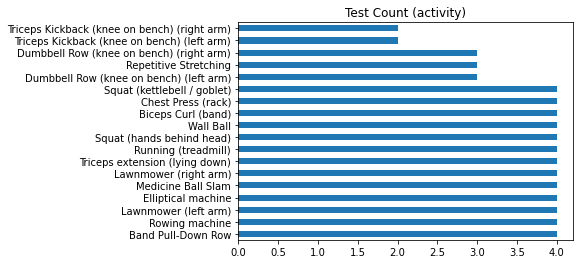

In [22]:
test_set_counts = test_set.activity.value_counts()
test_set_counts[test_set_counts < 5].plot(kind='barh', title='Test Count (activity)')

<AxesSubplot:title={'center':'Train Count (activity)'}>

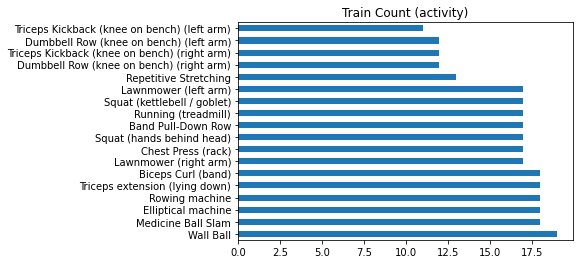

In [20]:
train_activity_counts = train_set.activity.value_counts()
train_activity_counts[train_activity_counts < 20].plot(kind='barh', title='Train Count (activity)')

<AxesSubplot:title={'center':'Incorrect Count (activity)'}>

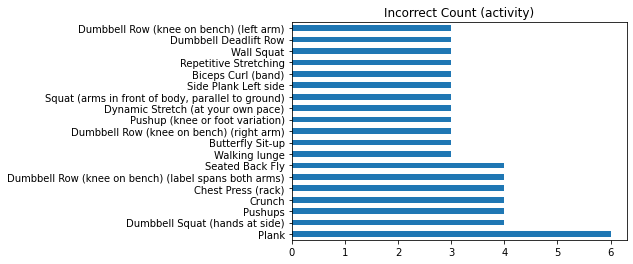

In [23]:
incorrect_counts = incorrect_df.activity.value_counts()
incorrect_counts[incorrect_counts > 2].plot(kind='barh', title='Incorrect Count (activity)')